In [1]:
import numpy as np
np.random.seed(1)

import scipy

import time

# grAdapt
import grAdapt
from grAdapt.space.datatype import Float
from grAdapt.models import Sequential
from grAdapt.surrogate import NoGradient, NoModel, GPRSlidingWindow
from grAdapt.optimizer import AMSGradBisection, AMSGrad

# scikit learn k Means for comparison
import sklearn as sk

# plot
import matplotlib.pyplot as plt

## 1. Introduction

In clustering we want to find centroids which minimize the variance of each cluster. This can be formulated in an optimization problem by minimizing the sum of the distances of each sample to its centroid. Similar to $k$-means, we set a fixed $k$ which is the predefined number of centroids. When treating this problem as a black-box, the search for a $kd$ vector which represents the $k$ centroids in the $d$ dimensional space. Of course, this formulation projects the initial problem to a much higher dimension.

### 1.1 Creating Artificial Data Clusters

In [2]:
import os
plot_path = 'plots/'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

In [3]:
cluster1 = np.random.multivariate_normal(np.array([3, 3]), np.eye(2), size=500)
cluster2 = np.random.multivariate_normal(np.array([-3, -3]), np.eye(2), size=500)
cluster3 = np.random.multivariate_normal(np.array([-3, 3]), np.eye(2), size=500)
cluster4 = np.random.multivariate_normal(np.array([3, -3]), np.eye(2), size=500)
dataset = np.vstack([cluster1, cluster2, cluster3, cluster4])

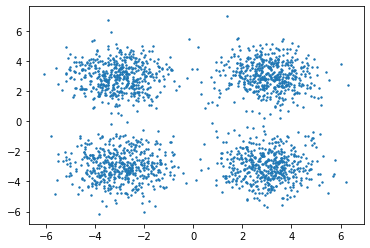

In [4]:
plt.scatter(dataset[:,0], dataset[:,1], s=2)
plt.show()

## 2. Define Black-Box

In [5]:
def variance_minimization(centroids):
    # reshape (k*d, ) to (k, d)
    centroids = centroids.reshape(-1, 2)
    
    # closest point
    dists = grAdapt.utils.math.spatial.pairwise_distances(dataset, centroids)
    # dists = scipy.spatial.distance.cdist(dataset, centroids)
    
    # assign
    j_opt = np.sum(np.amin(dists, axis=1))
    
    return j_opt

## 3. Creating grAdapt instance

In [6]:
# assuming we have 4 clusters
# each of the four clusters has x and y-values
# they are contrained in the following:

upper1, upper2 = np.amax(dataset, axis=0)
lower1, lower2 = np.amin(dataset, axis=0)

firstCentroid1 = Float(lower1, upper1)
firstCentroid2 = Float(lower2, upper2)

secondCentroid1 = Float(lower1, upper1)
secondCentroid2 = Float(lower2, upper2)

thirdCentroid1 = Float(lower1, upper1)
thirdCentroid2 = Float(lower2, upper2)

forthCentroid1 = Float(lower1, upper1)
forthCentroid2 = Float(lower2, upper2)

bounds = [firstCentroid1, firstCentroid2, secondCentroid1, secondCentroid2,
         thirdCentroid1, thirdCentroid2, forthCentroid1, forthCentroid2]

Try different surrogates

In [7]:
surrogate = GPRSlidingWindow()
model = Sequential(surrogate=surrogate, random_state=1)
n_evals = 1000
res_gpr = model.minimize(variance_minimization, bounds, n_evals)

 37%|████████████████████████████████▎                                                      | 371/1000 [00:00<?, ?it/s]

Sampling 371 random points.
Random function evaluations. This might take a while.
Finding optimum...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.45it/s]


In [8]:
surrogate = NoModel()
model = Sequential(surrogate=surrogate, random_state=1)
n_evals = 1000
res_nomodel = model.minimize(variance_minimization, bounds, n_evals)

 25%|███████████████████▏                                                         | 249/1000 [00:00<00:00, 2466.78it/s]

Sampling 371 random points.
Random function evaluations. This might take a while.


 37%|████████████████████████████████▎                                                      | 371/1000 [00:00<?, ?it/s]

Finding optimum...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:43<00:00,  3.53it/s]


In [9]:
surrogate = NoModel()
optimizer = AMSGrad(surrogate=surrogate)
model = Sequential(surrogate=surrogate, optimizer=optimizer, random_state=1)
n_evals = 1000
res_nomodel_amsgrad = model.minimize(variance_minimization, bounds, n_evals)

 37%|████████████████████████████████▎                                                      | 371/1000 [00:00<?, ?it/s]

Sampling 371 random points.
Random function evaluations. This might take a while.
Finding optimum...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:33<00:00,  4.68it/s]


In [10]:
surrogate = NoGradient()
model = Sequential(surrogate=surrogate, random_state=1)
n_evals = 1000
res_nogradient = model.minimize(variance_minimization, bounds, n_evals)

 32%|████████████████████████▉                                                    | 324/1000 [00:00<00:00, 2833.63it/s]

Sampling 371 random points.
Random function evaluations. This might take a while.


 46%|████████████████████████████████████▏                                         | 464/1000 [00:00<00:00, 928.11it/s]

Finding optimum...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1903.82it/s]


### 3.1 Plot solution with grAdapt

In [13]:
def plot_grAdapt_solution(centroids, filename='grAdapt_solution.pdf'):
    #plt.figure(figsize=(7,7))
    plt.scatter(dataset[:,0], dataset[:,1], s=1, c='blue', label='Data points')
    plt.scatter(centroids[:,0], centroids[:,1], c='red', label='Centroids')
    #plt.title('grAdapt solution')
    plt.legend(loc='upper right', fontsize='medium')
    
    #plt.xticks(fontsize=20)
    #plt.yticks(fontsize=20)
    
    plot_filepath = plot_path+filename
    plt.savefig(plot_filepath, bbox_inches='tight')
    plt.show()

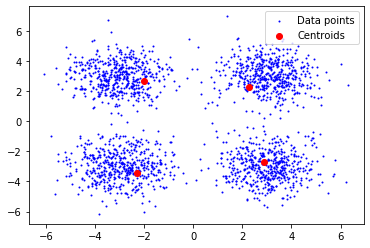

In [14]:
centroids_grAdapt = res_gpr['x_sol'].reshape(-1, 2)
plot_grAdapt_solution(centroids_grAdapt, 'grAdapt_solution_gpr.pdf')

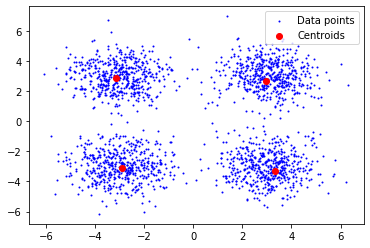

In [15]:
centroids_grAdapt = res_nomodel['x_sol'].reshape(-1, 2)
plot_grAdapt_solution(centroids_grAdapt, 'grAdapt_solution_nomodel.pdf')

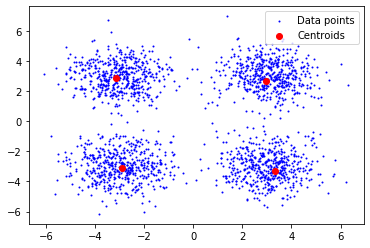

In [16]:
centroids_grAdapt = res_nomodel['x_sol'].reshape(-1, 2)
plot_grAdapt_solution(centroids_grAdapt, 'grAdapt_solution_nomodel_amsgrad.pdf')

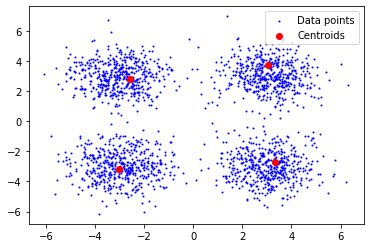

In [17]:
centroids_grAdapt = res_nogradient['x_sol'].reshape(-1, 2)
plot_grAdapt_solution(centroids_grAdapt, 'grAdapt_solution_nogradient.pdf')

### 3.2 Plot Training Loss

In [18]:
def plot_grAdapt_loss(res):
    plt.figure(figsize=(4,3))
    plt.plot(res['y'], linewidth=1)
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')

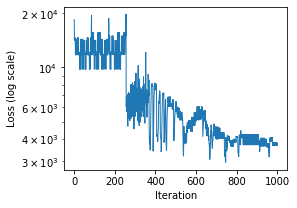

In [19]:
plot_grAdapt_loss(res_gpr)

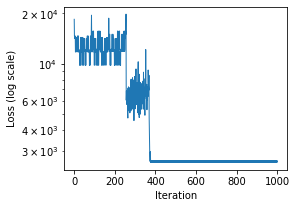

In [21]:
plot_grAdapt_loss(res_nomodel)

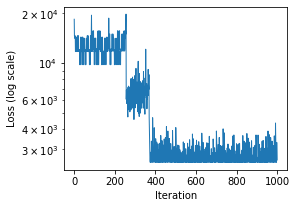

In [23]:
plot_grAdapt_loss(res_nomodel_amsgrad)

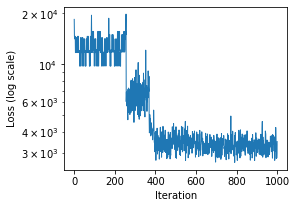

In [25]:
plot_grAdapt_loss(res_nogradient)

In [26]:
print(res_gpr['y_sol'])
print(res_nomodel['y_sol'])
print(res_nomodel_amsgrad['y_sol'])
print(res_nogradient['y_sol'])

2964.8902631653814
2554.865933310738
2500.636358004805
2640.922735724021


## 4. BFGS (scipy)

In [27]:
import scipy

In [28]:
x0 = np.random.choice(len(dataset), 4)
x0 = dataset[x0].flatten()
res_scipy = scipy.optimize.minimize(variance_minimization, x0)

In [29]:
centroids_scipy = res_scipy.x.reshape(-1, 2)

### 4.1 Plot solution with scipy

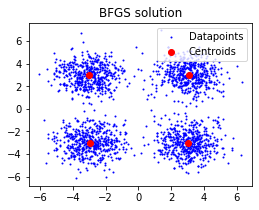

In [30]:
plt.figure(figsize=(4,3))
plt.scatter(dataset[:,0], dataset[:,1], s=1, c='blue', label='Datapoints')
plt.scatter(centroids_scipy[:,0], centroids_scipy[:,1], c='red', label='Centroids')
plt.title('BFGS solution')
plt.legend(loc='upper right')
plt.show()

In [31]:
res_scipy

      fun: 2500.6156224034357
 hess_inv: array([[ 2.63666101e-03,  6.24710176e-04, -6.21250013e-04,
         8.81911957e-04,  5.34825519e-05, -7.94068341e-04,
        -4.49083483e-05, -4.14551341e-04],
       [ 6.24710176e-04,  2.90884918e-03,  4.69640511e-04,
         1.54396677e-04, -2.30930137e-04,  3.48569256e-05,
         4.18800827e-04,  4.62360469e-05],
       [-6.21250013e-04,  4.69640511e-04,  2.81115209e-03,
        -6.10941342e-04,  4.61429790e-04,  4.67329399e-04,
        -8.37643205e-04, -2.77731316e-05],
       [ 8.81911957e-04,  1.54396677e-04, -6.10941342e-04,
         2.59498259e-03, -5.17422092e-04, -2.68264889e-04,
        -3.95649852e-04, -4.79854238e-04],
       [ 5.34825519e-05, -2.30930137e-04,  4.61429790e-04,
        -5.17422092e-04,  3.18764939e-03, -4.67737879e-04,
         5.14963133e-04,  1.61055167e-04],
       [-7.94068341e-04,  3.48569256e-05,  4.67329399e-04,
        -2.68264889e-04, -4.67737879e-04,  2.56236211e-03,
         3.76526021e-04,  3.34726868

## 5. k-Means

In [32]:
from sklearn.cluster import KMeans

In [33]:
kmeans = KMeans(n_clusters=4, random_state=1).fit(dataset)

In [34]:
centroids_kmeans = kmeans.cluster_centers_

In [35]:
loss_kmeans = variance_minimization(centroids_kmeans.flatten())

### 5.1 Plot solution with k-Means

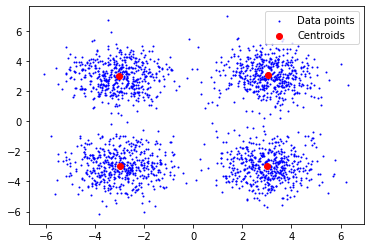

In [36]:
plot_grAdapt_solution(centroids_kmeans, 'kmeans_solution.pdf')

### 5.2 Plot Loss with k-Means solution

In [72]:
def plot_grAdapt_kMeans():
    #plt.figure(figsize=(4,3))
    #plt.figure(figsize=())
    #plt.figure(figsize=(7.5, 4.5))
    #plt.title('Loss of variance minimization')
    plt.plot(res_gpr['y'], label='grAdapt (GPR)')
    plt.plot(res_nomodel['y'], label='grAdapt (No Model)')
    #plt.plot(res_nomodel_amsgrad['y'], label='grAdapt (No Model, AMSGrad)')
    plt.plot(res_nogradient['y'], label='grAdapt (No Gradient)')
    plt.plot(np.arange(len(res_gpr['y'])), loss_kmeans * np.ones((len(res_gpr['y']),)), label='k-means base solution')
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.yscale('log')

    plot_filepath = plot_path+'loss_variance_minimization.pdf'
    plt.savefig(plot_filepath, bbox_inches='tight')
    plt.show()

def plot_grAdapt_kMeans2():
    #plt.figure(figsize=(4,3))
    #plt.figure(figsize=())
    #plt.figure(figsize=(7.5, 4.5))
    #plt.title('Loss of variance minimization')
    plt.plot(res_gpr['y'], label='grAdapt (GPR)')
    #plt.plot(res_nomodel['y'], label='grAdapt (No Model)')
    plt.plot(res_nomodel_amsgrad['y'], label='grAdapt (No Model, AMSGrad)')
    plt.plot(res_nogradient['y'], label='grAdapt (No Gradient)')
    plt.plot(np.arange(len(res_gpr['y'])), loss_kmeans * np.ones((len(res_gpr['y']),)), label='k-means base solution')
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.yscale('log')

    plot_filepath = plot_path+'loss_variance_minimization_amsgrad.pdf'
    plt.savefig(plot_filepath, bbox_inches='tight')
    plt.show()

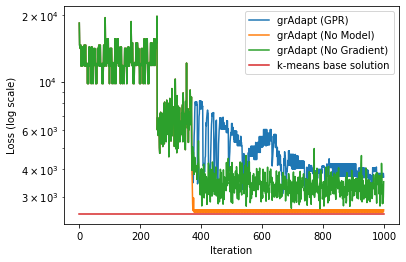

In [73]:
plot_grAdapt_kMeans()

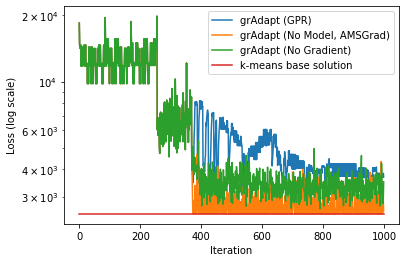

In [74]:
plot_grAdapt_kMeans2()

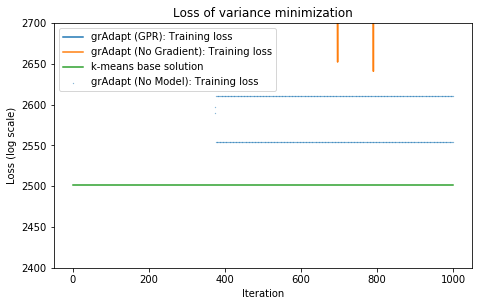

In [216]:
#plt.figure(figsize=(4,3))
#plt.figure(figsize=())
plt.figure(figsize=(7.5, 4.5))
plt.title('Loss of variance minimization')
plt.plot(res_gpr['y'], label='grAdapt (GPR): Training loss')
plt.scatter(np.arange(len(res_gpr['y'])), res_nomodel['y'], s=0.05, label='grAdapt (No Model): Training loss')
plt.plot(res_nogradient['y'], label='grAdapt (No Gradient): Training loss')
plt.plot(np.arange(len(res_gpr['y'])), loss_kmeans * np.ones((len(res_gpr['y']),)), label='k-means base solution')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
#plt.yscale('log')
plt.ylim(2400, 2700)

# plot_filepath = plot_path+'loss_variance_minimization.pdf'
plt.savefig(plot_filepath, bbox_inches='tight')
plt.show()

In [75]:
# grAdapt
print(res_gpr['y_sol'])
print(res_nomodel['y_sol'])
print(res_nomodel_amsgrad['y_sol'])
print(res_nogradient['y_sol'])

2964.8902631653814
2554.865933310738
2500.636358004805
2640.922735724021


In [32]:
# scipy
res_scipy.fun

2500.6156224034357

In [85]:
# kmeans
loss_kmeans

2501.1269386698177

In [86]:
res_gpr['x_sol']

array([ 2.27221464,  2.27688557, -2.26863599, -3.42615316,  2.89398704,
       -2.73418214, -1.99525693,  2.69005616])

In [87]:
res_nomodel['x_sol']

array([ 2.97878907,  2.65203842, -2.88016755, -3.11398741,  3.31755858,
       -3.30360669, -3.12550566,  2.83057301])

In [88]:
res_nomodel_amsgrad['x_sol']

array([ 3.0682923 ,  3.01407241, -2.95276453, -3.00447629,  3.03641009,
       -3.02961352, -3.03138963,  2.9581154 ])

In [89]:
res_nogradient['x_sol']

array([ 3.05096674,  3.73225768, -3.01564769, -3.15579978,  3.3248289 ,
       -2.74265177, -2.55963199,  2.82830997])

In [90]:
centroids_kmeans[:,0]

array([ 3.04714251, -2.9678591 , -3.02779947,  3.00746633])

In [91]:
centroids_kmeans[:,1]

array([ 3.03078099, -2.98442207,  2.97829029, -3.0002689 ])